In [1]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Machine Learning

## Introdução a Inteligência Artificial

Aluno: Luiz Philippe Pereira Amaral

## Dataset

In [2]:
iris = load_iris()
df = pd.DataFrame({
    'sepal length': iris.data[:, 0],
    'sepal width': iris.data[:, 1],
    'petal length': iris.data[:, 2],
    'petal width': iris.data[:, 3],
    'target': iris.target,
    'target_name': [ iris.target_names[t] for t in iris.target ]
})

data_columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'target', 'target_name']
data = df.to_numpy()[:, :-2]
targets = df.to_numpy()[:, -2]

In [3]:
df

,sepal length,sepal width,petal length,petal width,target,target_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


## Utils

In [4]:
def euclidean_distance(arr1, arr2):
    d = 0
    for a, b in zip(arr1, arr2):
        d += (a - b)**2
    
    return d**(1/2)

def get_average(ndarr):
    rows, columns = ndarr.shape
    res = np.zeros(columns, dtype=float)
    for i in range(rows):
        res = (res + ndarr[0])
            
    res /= rows
        
    return res

def plot_classification(df, columns, targets=[], colors=['#744CEB', '#34EB41', '#EBA363']):
    plt.xlabel(columns[0])
    plt.ylabel(columns[1])
    samples = len(df.index)
    
    c = 'black'
    if len(targets) == samples:
        c = [ colors[targets[i]] for i in range(samples) ]
    
    plt.scatter(x = df[columns[0]], y = df[columns[1]], c = c)

## Aprendizado não supervisionado: K-means

### Métodos intermediários

In [5]:
def find_centroids(data, classifications, k):
    groups = [ data[np.where(classifications == i)] for i in range(k) ]
    centroids = np.ndarray((k, data.shape[1]))
    for i in range(k):
        centroids[i] = get_average(groups[i])
    return centroids

def get_classifications(data, centroids, k):
    classifications = np.zeros(data.shape[0], dtype=int)
    
    for i in range(data.shape[0]):
            distance = np.zeros(k)
            for j in range(k):
                distance[j] = euclidean_distance(data[i], centroids[j])

            classifications[i] = distance.tolist().index(distance.min())
            
    return classifications

### Implementação

In [6]:
def kmeans(k, data):
    samples, features = data.shape
    idx = np.random.randint(samples, size=k)
    centroids = data[idx, :]
    
    classifications = np.zeros(samples, dtype=int)
    
    delta = float('inf')
    
    while not np.isclose(delta, 0):
        classifications = get_classifications(data, centroids, k)
        new_centroids = find_centroids(data, classifications, k)
        delta = np.sum([ euclidean_distance(centroids[i], new_centroids[i]) for i in range(k) ])
        centroids = new_centroids
    
    
    classifications = get_classifications(data, centroids, k)
    return (centroids, classifications)

### Resultados

#### K = 2

In [7]:
centroids, classifications = kmeans(2, data)
print(centroids)

[[5.1 3.5 1.4 0.2]
 [7.  3.2 4.7 1.4]]


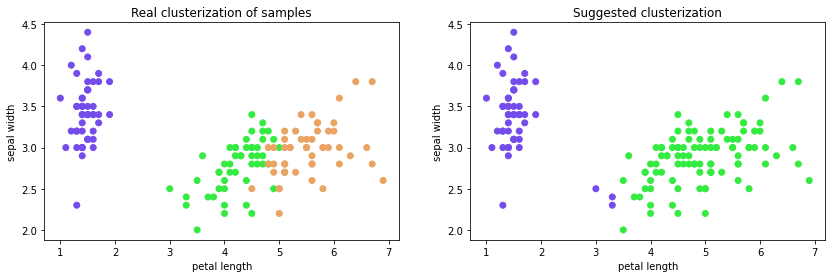

In [8]:
columns = ['petal length', 'sepal width']
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.title('Real clusterization of samples')
plot_classification(df, columns, targets)

plt.subplot(1, 2, 2)
plt.title('Suggested clusterization')
plot_classification(df, columns, classifications)

plt.show()

#### K = 3

In [19]:
centroids, classifications = kmeans(3, data)
print(centroids)

[[5.1 3.5 1.4 0.2]
 [7.  3.2 4.7 1.4]
 [6.3 3.3 6.  2.5]]


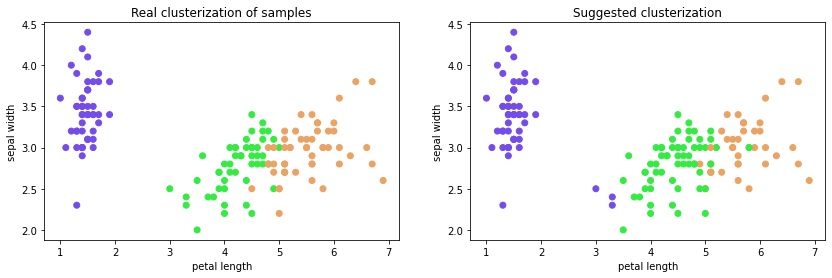

In [20]:
columns = ['petal length', 'sepal width']
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.title('Real clusterization of samples')
plot_classification(df, columns, targets)

plt.subplot(1, 2, 2)
plt.title('Suggested clusterization')
plot_classification(df, columns, classifications)

plt.show()

## Aprendizado supervisionado: KNN

### Conjuntos de treino e teste

In [49]:
samples, features = data.shape

shuffle_data = df.to_numpy()[:, :-1]
np.random.shuffle(shuffle_data)

split = int(len(data) * 0.8)

train_data = shuffle_data[:split]
test_data = shuffle_data[split:]

print((len(train_data), len(test_data)))

(120, 30)


### Utils

In [50]:
def get_accuracy(confusion_matrix):
    t = np.sum([ confusion_matrix[i, i] for i in range(len(confusion_matrix)) ])
    f = np.sum(confusion_matrix)
    return t/f

### Implementação

In [51]:
def knn(k, data, labels, sample):
    distances = np.zeros((len(data), 2))
    
    for i in range(len(data)):
        distances[i] = [i, euclidean_distance(data[i], sample)]
        
    distances = distances[distances[:, 1].argsort()]
    knearest = distances[:k]
    
    nearest_labels = [ labels[int(neighbor[0])] for neighbor in knearest ]
    vals,counts = np.unique(nearest_labels, return_counts=True)
    index = np.argmax(counts)
    label = vals[index]
    
    return (knearest, label)
    

### Resultados

In [52]:
def get_confusion_matrix(k, train_data, test_data):
    labels_count = len(np.unique(train_data[:, -1]))
    confusion_matrix = np.zeros((labels_count, labels_count))
    
    for i in range(len(test_data)):
        _, label = knn(k, train_data[:, :-1], train_data[:, -1], test_data[i, :-1])
        confusion_matrix[test_data[i, -1], label] += 1
    
    return confusion_matrix

#### K = 2

In [53]:
confusion_k2 = get_confusion_matrix(2, train_data, test_data)
accuracy_k2 = get_accuracy(confusion_k2)
print(confusion_k2)
print(f'Acurácia: {accuracy_k2}')

[[10.  0.  0.]
 [ 0.  9.  1.]
 [ 0.  1.  9.]]
Acurácia: 0.9333333333333333


#### K = 8

In [54]:
confusion_k8 = get_confusion_matrix(8, train_data, test_data)
accuracy_k8 = get_accuracy(confusion_k8)
print(confusion_k8)
print(f'Acurácia: {accuracy_k8}')

[[10.  0.  0.]
 [ 0.  9.  1.]
 [ 0.  1.  9.]]
Acurácia: 0.9333333333333333


#### K = 32

In [57]:
confusion_k32 = get_confusion_matrix(32, train_data, test_data)
accuracy_k32 = get_accuracy(confusion_k32)
print(confusion_k32)
print(f'Acurácia: {accuracy_k32}')

[[10.  0.  0.]
 [ 0.  9.  1.]
 [ 0.  1.  9.]]
Acurácia: 0.9333333333333333


#### K = 64

In [59]:
confusion_k64 = get_confusion_matrix(64, train_data, test_data)
accuracy_k64 = get_accuracy(confusion_k64)
print(confusion_k64)
print(f'Acurácia: {accuracy_k64}')

[[10.  0.  0.]
 [ 0. 10.  0.]
 [ 0.  4.  6.]]
Acurácia: 0.8666666666666667
